# Cvičení 02 -Rozhodovací stromy
  
  * V tomto notebooku byste se měli naučit, jak vytvořit (naučit) model dat ve formě rozhodovacího stromu.
  * Ukážeme si typický způsob, jak se toto dělá a představíme si i základní API knihovny `sklearn`.
  * Začneme s daty a skončíme s naučeným modelem, o kterém budeme tušit, jak je dobrý.

In [41]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

## Data: základní přehled

  * Použijeme balíček `pandas` k nahrání dat a jejich základnímu prozkoumání.
  * Data jsme stáhli ze serveru **kaggle.com**, kde můžete také najít [popis jednotlivých příznaků](https://www.kaggle.com/uciml/adult-census-income).

In [42]:
data = pd.read_csv('adult-census.csv')
display(data.shape)
display(data.head())
# display(data.info())
display(data.describe())
display(data.nunique()) # počet unikátních hodnot, defaultně ignoruje NaNs

(32561, 15)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

## Příprava dat před použitím modelu

Zkuste si později sami, že když vezmete aktuální data a pokusíte se je vložit do modelu `DecisionTreeClassifier`, který záhy budeme používat, tak to neprojde. 

Implementace rozhodovacího stromu v `sklearn` si neumí poradit s nečíselnými (nenumerickými) příznaky.
  * Musíme proto nahradit stringy nějakými jejich kódy.
  * **ÚKOL:** Zjistěte, jaký je vztah mezi příznaky *education* a *education.num*. 

In [43]:
### sem přijde Váš kód
edu = data[["education", "education.num"]].drop_duplicates()
edu.sort_values(by="education.num")
# příp. i s počty:
#data.sort_values(by="education.num").groupby(by=["education", "education.num"])["education", "education.num"].sum().sort_index(level=1)

,education,education.num
1106,Preschool,1
26,1st-4th,2
27,5th-6th,3
3,7th-8th,4
197,9th,5
6,10th,6
16,11th,7
178,12th,8
0,HS-grad,9
2,Some-college,10


Vidíme, že `education.num` je vlastně číselná reprezentace té kategorie `education`.
Jedná se tedy o redundantní informaci, kterou v za chvíli odstraníme.

### Chybějící hodnoty
  * Některé příznaky jsou očividně nevyplněné, ale `pandas` hlásí, že žádné nechybí. Je to tím, že chybějící hodnoty nejsou zakódované jako `NaN` ale jsou nahrazeny otazníkem `?`.

In [44]:
data = data.replace('?', np.nan)
# podívejme se na výsledek
data.info()
data.isnull().sum(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

### Převod textových dat na kategorická data

Nejprve se podívejme, jaké jsou nečíselné příznaky.

In [45]:
display(data.dtypes)
display(data.nunique())
string_cols = data.select_dtypes(['object']).columns
print(string_cols)
data[string_cols].nunique()

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

age                  73
workclass             8
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           14
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       41
income                2
dtype: int64

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')


workclass          8
education         16
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
income             2
dtype: int64

  * Všechny příznaky s hodnotami typu string nejsou spojité, ale tzv. **kategorické** (diskrétní).
  * Můžeme je tedy všechny nahradit číselnými kódy.
  * Je v `pandas` nějaká metoda, která to umí? Samozřejmě ano. Je ale nutné typ příznaku v `pandas` změnit na `category`.
  
Pro příznaky `income` a `education` definujeme kategorie ručně, abychom mohli zavést i uspořádání a ty číselné reprezentace aby to uspořádání respektovali (jedná se o takzvaná ordinální data).

U ostatních příznaků to necháme pandas udělat automaticky.

In [46]:
data.income.unique()

array(['<=50K', '>50K'], dtype=object)

In [47]:
income_category = pd.api.types.CategoricalDtype(categories=['<=50K', '>50K'], ordered=True)
data['income'] = data['income'].astype(income_category)

In [48]:
string_cols = data.select_dtypes(['object']).columns
print(string_cols)

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country'],
      dtype='object')


Pro `education` využijeme již existující analýzy a z ní získaného uspořádání.

**Úkol:** Proveďte analogickou transformaci jako u `income`, ale využijte seřazení v `edu.sort_values(by="education.num")`

In [49]:
display(edu.sort_values(by="education.num"))

,education,education.num
1106,Preschool,1
26,1st-4th,2
27,5th-6th,3
3,7th-8th,4
197,9th,5
6,10th,6
16,11th,7
178,12th,8
0,HS-grad,9
2,Some-college,10


In [50]:
### sem přijde Váš kód
edu_category = pd.api.types.CategoricalDtype(categories=edu.sort_values(by="education.num").education.values, ordered=True)
data['education'] = data['education'].astype(edu_category)

Ještě je převedeme na číselnou reprezentaci pomocí `...cat.codes`

In [51]:
data.income = data.income.cat.codes
data.education = data.education.cat.codes
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,8,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,8,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,NaN,186061,9,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,3,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,9,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [52]:
data.drop('education.num', axis = 1, inplace = True)

In [53]:
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)
data.info()
# funguje to?
data["native.country"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int8 
 2   fnlwgt          32561 non-null  int64
 3   education       32561 non-null  int8 
 4   marital.status  32561 non-null  int8 
 5   occupation      32561 non-null  int8 
 6   relationship    32561 non-null  int8 
 7   race            32561 non-null  int8 
 8   sex             32561 non-null  int8 
 9   capital.gain    32561 non-null  int64
 10  capital.loss    32561 non-null  int64
 11  hours.per.week  32561 non-null  int64
 12  native.country  32561 non-null  int8 
 13  income          32561 non-null  int8 
dtypes: int64(5), int8(9)
memory usage: 1.5 MB


array([38, -1, 25, 11, 39,  2, 35, 18, 29, 37,  1, 34, 14, 32, 30, 19,  8,
       10, 21, 23, 16, 15,  4, 20,  0, 28, 26,  5, 13,  7, 17,  3, 12, 22,
        6,  9, 40, 33, 31, 24, 36, 27], dtype=int8)

### Chybějící hodnoty

* Co se stalo s `NaN` položkami?

**Chybějící hodnoty byly nahrazeny -1!**

Jak se vypořádat s chybějícími hodnotami je docela věda. Jejich nahrazení jedinou unikátní hodnotou je takový nejjednodušší (a skutečně používaný) způsob.

In [54]:
data = data.replace('?', np.nan)
# podívejme se na výsledek
# data.info()
data.isnull().sum(axis=0)
display(data.head(20))

,age,workclass,fnlwgt,education,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,-1,77053,8,6,-1,1,4,0,0,4356,40,38,0
1,82,3,132870,8,6,3,1,4,0,0,4356,18,38,0
2,66,-1,186061,9,6,-1,4,2,0,0,4356,40,38,0
3,54,3,140359,3,0,6,4,4,0,0,3900,40,38,0
4,41,3,264663,9,5,9,3,4,0,0,3900,40,38,0
5,34,3,216864,8,0,7,4,4,0,0,3770,45,38,0
6,38,3,150601,5,5,0,4,4,1,0,3770,40,38,0
7,74,6,88638,15,4,9,2,4,0,0,3683,20,38,1
8,68,0,422013,8,0,9,1,4,0,0,3683,40,38,0
9,41,3,70037,9,4,2,4,4,1,0,3004,60,-1,1


## Příprava trénovací a validační množiny pro učení stromu

Nejprve si oddělíme cílovou proměnnou, kterou chceme predikovat.
V našem případě se jedná o **income**.

In [55]:
Xdata = data.drop("income", axis = 1)
ydata = data.income

K rozdělení dat použijeme [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) ze `sklearn`.

Tato funkce nám umožní rozdělit data (pseudo-náhodně) na dvě části. Pomocí opakovaného použití tak můžeme postupně vytvořit **trénovací**, **validační** a **testovací** část dat.

Data rozdělíme tak, aby 60% bylo trénovací, 20% validační a 20% testovací.

In [56]:
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.4, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xtest.shape)
display(ytest.shape)

(19536, 13)

(19536,)

(13025, 13)

(13025,)

In [57]:
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=rd_seed) 
display(Xval.shape)
display(yval.shape)
display(Xtest.shape)
display(ytest.shape)

(6512, 13)

(6512,)

(6513, 13)

(6513,)

## Vlastní částečná implementace stromu

Vytvoříme si pouze to prvotní dělení a nebude řešit otázku predikce. Pouze, abychom posléze viděli, že využití modelu z knihovny `scikit-learn` počítá to samé.

Jako kritérium při optimalizaci použijeme Gini index definovaý v pro dvě třídy přednášce jako $$GI = p_0(1-p_0) + p_1(1 - p_1),$$
kde $p_i$ je odhad pravděpodobnosti výskytu třídy $i$. V našem případě je $p_1$ počet $1$ dělený počtem všech a $p_0$ počet $0$ dělený počtem všech.  

Nejprve si naimplementujme funkci, které když dáme nějaký vektor (`series`) hodnot `y`, tak vrátí Gini index tohoto kousku.

In [58]:
def GI(y):
    p = y.mean()
    return 2*p*(1-p)

Dále si připravme počáteční hodnoty a pomocnou strukturu na ukládání aktuálního nejlepšího dělení.

In [59]:
initGI = GI(ytrain)
print(f"Initial Gini {initGI}")
n = ytrain.shape[0]
print(f"N: {n}")

optimal = {'IG': 0,
          'col': None,
          'thr_val': None,
          'GI': 0,
          'GI1': 0,
          'GI2': 0,
          'N1': 0,
          'N2': 0}

Initial Gini 0.36646429766822886
N: 19536


A nyní už můžeme iterovat přes příznaky a přes všechny možné thresholdy a hledat optimální

In [60]:
# iterate columns
for col in Xtrain.columns:
    print(f'Processing column {col}')
    # najdeme threshold
    values = sorted(Xtrain[col].unique())
    thrs = [(values[i-1] + values[i])/2 for i in range(1,len(values))]
    for thr_val in thrs:
        ind = Xtrain[col] <= thr_val
        t1 = (ind.sum())/n
        t2 = 1-t1
        # když je to alespoň nějaké dělení
        if t1 > 0 and t1 < 1:
            GI1 = GI(ytrain[ind])
            GI2 = GI(ytrain[~ind])
            IG = initGI - t1*GI1 - t2*GI2
            if IG > optimal['IG']:
                optimal.update(IG=IG, col=col, thr_val = thr_val, GI = initGI, GI1 = GI1, GI2 = GI2, N1 = ind.sum(), N2 = (~ind).sum())

Processing column age
Processing column workclass
Processing column fnlwgt
Processing column education
Processing column marital.status
Processing column occupation
Processing column relationship
Processing column race
Processing column sex
Processing column capital.gain
Processing column capital.loss
Processing column hours.per.week
Processing column native.country


Zobrazme si výsledek

In [61]:
print(f"Dělení podle sloupce: {optimal['col']} s thresholdem {optimal['thr_val']}")
print(f"Originální Gini index: {optimal['GI']}\n")
print(f"Optimální IG: {optimal['IG']}")
print(f"Počty bodů po rozdělení: {optimal['N1']} a {optimal['N2']}")
print(f"Gini indexy po rozdělení: {optimal['GI1']} a {optimal['GI2']}")

Dělení podle sloupce: relationship s thresholdem 0.5
Originální Gini index: 0.36646429766822886

Optimální IG: 0.057948407723582576
Počty bodů po rozdělení: 7923 a 11613
Gini indexy po rozdělení: 0.4945260635191403 a 0.1816099564881134


## Použití rozhodovacího stromu implementovaného v `sklearn`
 
 * [Zde](http://scikit-learn.org/stable/modules/tree.html) najdete dokumentaci k rozhodovacím stromům v balíčku `tree` knihovny `scikit-learn`.


In [62]:
from sklearn.tree import DecisionTreeClassifier

* V knihovně `scikit-learn` mají modely jednotný interface (API).
* Nejdříve se vždy nastaví hyperparametry modelu (jaké jsou k dispozici lze zjistit pomocí nápovědy) a "nastavený" model se uloží do proměnné:

In [63]:
clf = DecisionTreeClassifier(max_depth = 1)
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

* Model se pak "naučí" na datech pomocí metody `.fit()`. 
* V případě supervizovaných modelů vyžaduje většinou matici (`pandas.DataFrame`) s příznaky a vektor (`pandas.Series`) s vysvětlovanou proměnnou.

In [64]:
clf.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=1)

## Porovnání s naší vlastní implementací

Použijeme k tomu `plot_tree` funkci ze `sklearn`.

[Text(0.5, 0.75, 'relationship <= 0.5\ngini = 0.366\nsamples = 19536\nvalue = [14816, 4720]\nclass = y[0]'),
 Text(0.25, 0.25, 'gini = 0.495\nsamples = 7923\nvalue = [4376, 3547]\nclass = y[0]'),
 Text(0.75, 0.25, 'gini = 0.182\nsamples = 11613\nvalue = [10440, 1173]\nclass = y[0]')]

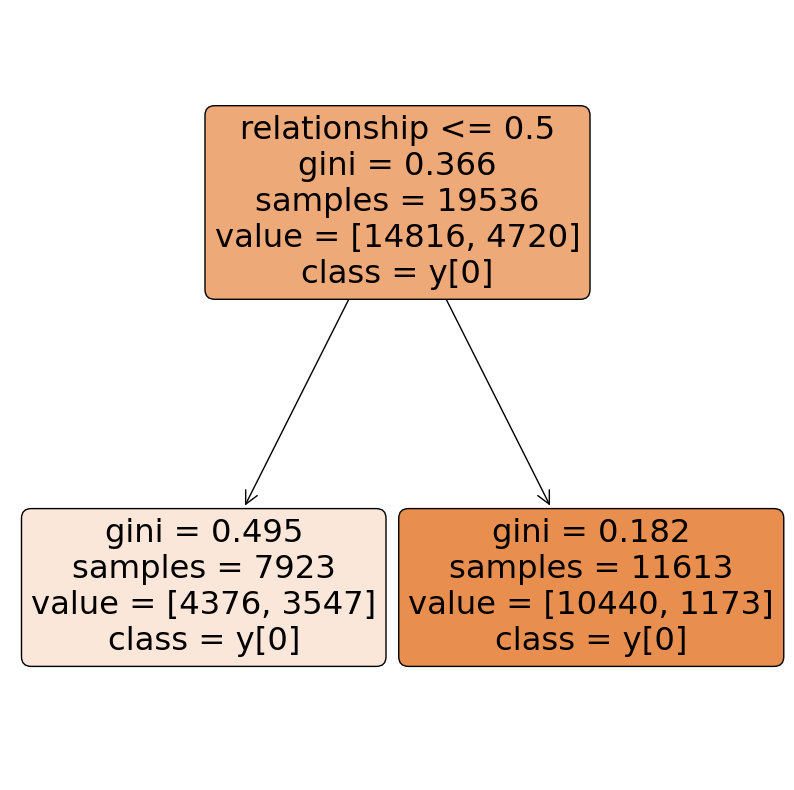

In [65]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,10))
plot_tree(clf, filled=True, feature_names=Xtrain.iloc[:,:].columns, class_names=True, rounded=True)

**Vidíme, že dostáváme to samé!**

V dalším už budeme pracovat pouze s implementací ze `sklearn`.

## Měření trénovací chyby pomocí klasifikační přesnosti

In [66]:
clf = DecisionTreeClassifier(max_depth=50)
clf.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=50)

  * Rozhodovací strom máme hotový, nyní můžeme použít metodu `predict()`, abychom získali predikce, které dává strom pro trénovací data.

In [67]:
ypredicted = clf.predict(Xtrain)
ypredicted

array([0, 0, 1, ..., 1, 0, 1], dtype=int8)

In [68]:
(ytrain - ypredicted).value_counts(normalize=True)

0    1.0
Name: income, dtype: float64

  * Přesnost na trénovacích datech je  (pro `max_depth` = 50) skoro 100 %! 
  * Měřit přesnost a různé metriky nemusíme takto ručně, v `sklearn` je na to samozřejmě balíček:

In [69]:
import sklearn.metrics as metrics
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clf.predict(Xtrain))))

accuracy score (train): 1.000000


S testovacími daty to tak skvěle nedopadne:

In [70]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, clf.predict(Xtest))))

accuracy score (test): 0.811300


### Ladění hyperparameterů `max_depth` a `criterion`

  * Začněme s hyperparametrem `max_depth`.
  * Jak víme, budeme používat validační množinu.
  * Prozkoumáme hodnoty od 1 do 100.

In [71]:
val_acc = []
train_acc = []
depths = range(1,101)
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))

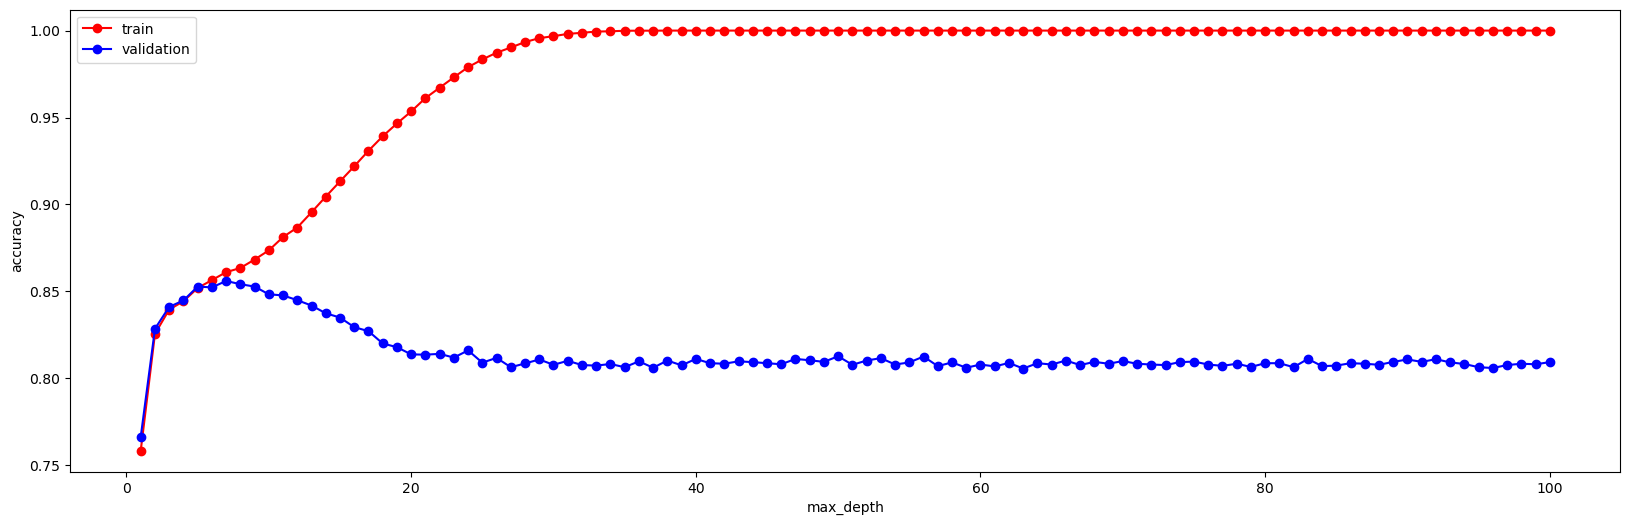

In [72]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(depths, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(depths, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [73]:
optimal_depth = np.argmax(val_acc) + 1
optimal_depth

7

Spočítejme **testovací accuracy** pro nejlepší nalezenou hodnotu `max_depth`:

In [34]:
clf = DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(Xtrain, ytrain)
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, clf.predict(Xtest))))

accuracy score (test): 0.857055


### Grid search: ladění více hyperparameterů

  * Chceme projít hodnoty `max_depth` z intervalu [1, 100] a obě možné hodnoty `criterion`, tj. 200 různých kombinací.
  * Můžeme samozřejmě použít dva vnořené for cykly (což je hrozné) nebo použít `ParameterGrid` balíček.

In [35]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)
# just to see the result:
[param_comb[i] for i in range(2)]

[{'max_depth': 1, 'criterion': 'entropy'},
 {'max_depth': 2, 'criterion': 'entropy'}]

In [36]:
val_acc = []
train_acc = []
for params in param_comb:
    clf = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    clf.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))

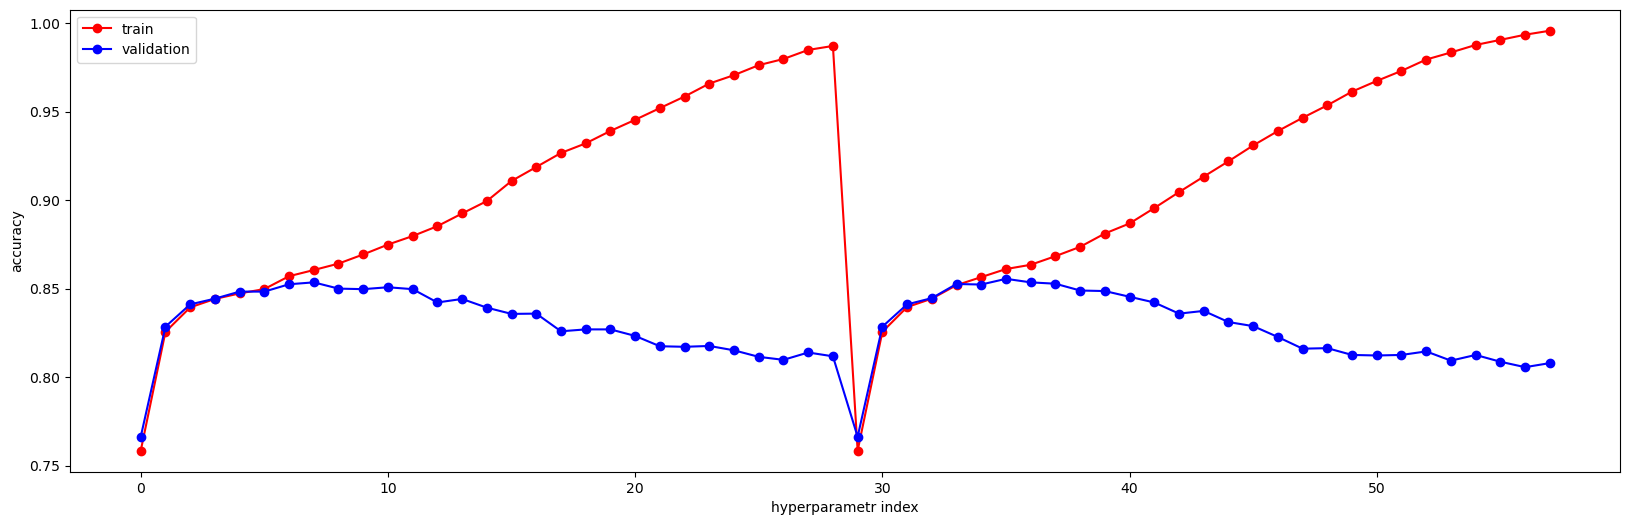

In [37]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [38]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'max_depth': 7, 'criterion': 'gini'}

In [39]:
clf = DecisionTreeClassifier(**best_params) # TOHOTO ŘÁDKU si všimněte: dvě hvězdišky jsou mocný nástroj
clf.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clf.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, clf.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, clf.predict(Xtest))))

accuracy score (train): 0.861026
accuracy score (validation): 0.855651
accuracy score (test): 0.856748


### ÚKOL: naučte strom na datech k Titaniku z minulého cvičení

  * Hyperparametry k tunění si vyberte sami.
  * Rozdělte data ve stejných poměrech a se stejným `random_state` v metode `train_test_split()` jeko výše.

,Survived,Pclass,Sex,FootSize,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,0,34.0,33.0,0,0,0,86.5000,9,2
1,0,3,1,NaN,NaN,0,0,81,14.5000,-1,2
2,0,3,1,NaN,41.0,0,0,118,7125.0000,-1,2
3,1,3,1,NaN,20.0,0,0,38,7.2292,-1,0
4,1,1,0,NaN,36.0,1,2,9,120.0000,11,2


,Survived,Pclass,Sex,FootSize,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,0,34.0,33.0,0,0,0,86.5000,9,2
1,0,3,1,-1.0,-1.0,0,0,81,14.5000,-1,2
2,0,3,1,-1.0,41.0,0,0,118,7125.0000,-1,2
3,1,3,1,-1.0,20.0,0,0,38,7.2292,-1,0
4,1,1,0,-1.0,36.0,1,2,9,120.0000,11,2


best params  {'max_depth': 7, 'criterion': 'gini'}
accuracy score (train): 0.986486
accuracy score (validation): 0.880000
accuracy score (test): 0.757576


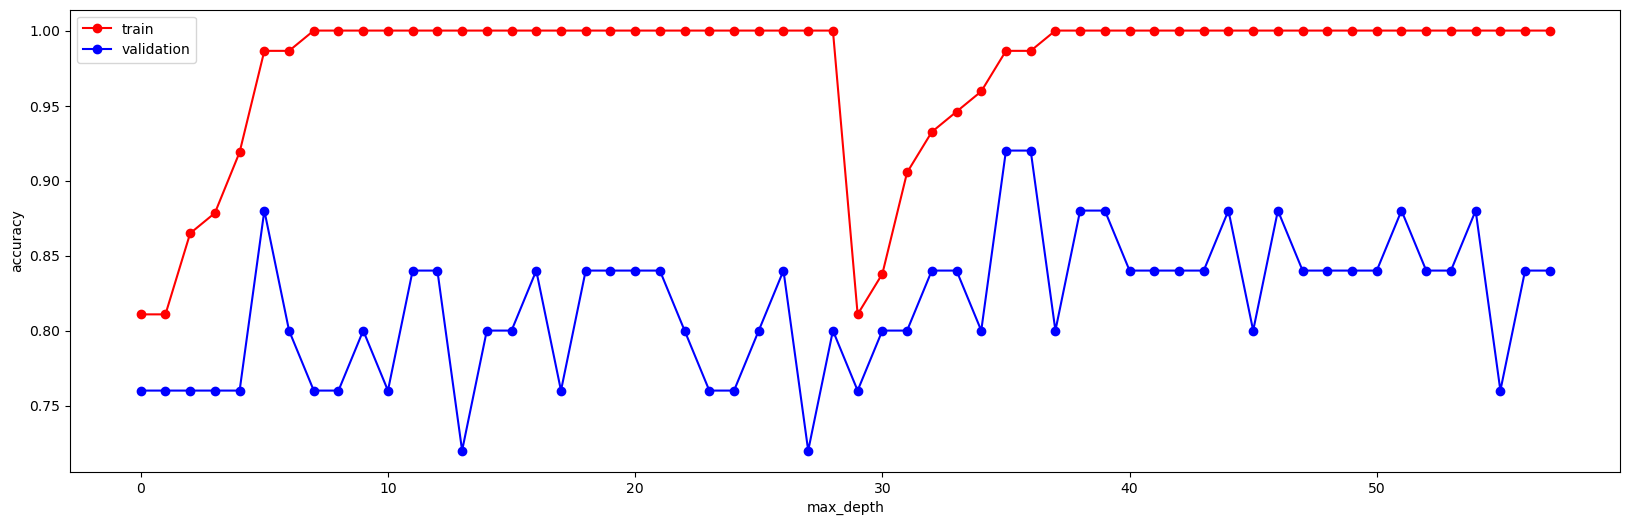

In [40]:
titanic = pd.read_csv('titanic.csv', sep=';')
### sem přijde Váš kód
titanic.nunique()
#  #unikátních hodnot = #řádků
titanic.drop(columns=["Name", "PassengerId"], inplace=True)

# kategorie
string_cols = titanic.select_dtypes(['object']).columns
titanic[string_cols] = titanic[string_cols].astype('category').apply(lambda x: x.cat.codes)
display(titanic.head())

# nahrazení nans
titanic = titanic.replace(np.nan, -1)
display(titanic.head())

# rozsekání dat
Xdata = titanic.iloc[:,1:]
ydata = titanic.iloc[:,0]

# copy paste
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
best_params = param_comb[np.argmax(val_acc)]
print('best params ', best_params)
dt = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'])
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

In [1]:
# Importing libraries
**pandas** for data manipulation and analysis <br>
**numpy** for numerical computing <br>
**matplotlib** for printing graphs <br>
**sklearn.metrics** for 'accuracy_score' function <br>
**train_test_split** for splitting data <br>
**DecisionTreeClassifier** for predictions with decision tree <br>
**KNeighborsClassifier** for predictions with KNN <br>
**MinMaxScaler** for normalize data <br>
**StandardScaler** for normalize data <br>
**ParameterGrid** for easier hyperparameter testing

SyntaxError: invalid syntax (3220902785.py, line 2)

In [2]:
# Check dataset

* Look at number of columns and rows
    * columns: 13
    * rows: 1000
* Find types of datatypes
    * *int64, object, float64*
* Check how missing values are represented
    * *NaN*

SyntaxError: invalid syntax (4136332271.py, line 3)

In [3]:
### Look at survival rate

* We have 1 000 rows -> 609 died, 391 survived

SyntaxError: invalid syntax (2789788257.py, line 3)

In [4]:
# Preparing dataset
* Decide what to do with columns we wont need
    * remove *ID, name, ticket, fare, cabin* from dataset
    * change **home.dest**: **1** -> have home.dest, **0** -> dont have
* Decide what to do with *NaN* values
    * **age**: *NaN* values -> **-1**
* Change object datatypes:
    * *Ordinal = object -> category -> use: cat.codes*
    * *Nominal = one-hot encoding -> use: pd.get_dummies()*
    * **sex** and **embarker** are nominal

SyntaxError: invalid syntax (3716853536.py, line 1)

In [5]:
# Decision tree
### Prepare explained variable and datasets

* Split data into train, validation and test datasets

SyntaxError: invalid syntax (424133507.py, line 4)

In [6]:
### Find best hyperparameters and let model learn

* Find best values for these hyperparameters (test all cases):
    * Depth = {1, 30}
    * Criterion = {entropy, gini}
* Learn model
    * Use best parameters and fit to train dataset
* Show results
    * Plot graph
    * Show accuracy

SyntaxError: invalid syntax (3206905553.py, line 3)

In [7]:
# Decision tree for evaluation.cvs

* Load new dataset into eval_data
* Correct dataset like in *data.csv*
* Create prediction with our best model on this dataset
* Save our prediction to new file called: *results.csv*

SyntaxError: invalid syntax (3752176488.py, line 3)

In [8]:
# KNN
### KNN without normalized data
* Find best values for these hyperparameters (test all cases):
    * Number of neighbors = {3, 20}
* Learn model
    * Use best parameters and fit to train dataset
* Show results
    * Plot graph
    * Show accuracy

SyntaxError: invalid syntax (2160670511.py, line 3)

In [9]:
### Normalize data
* Choose better method based on their accuricy
    * MinMaxScaler
    * StandardScaler


SyntaxError: invalid syntax (380168802.py, line 2)

In [10]:
### KNN with normalized data
* Learn model with normalized data
    * Find new best number of neighbors
* Normalize test data
* Show results
    * Plot graph
    * Show accuracy

SyntaxError: invalid syntax (942437485.py, line 2)